In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
from torchmetrics.regression import LogCoshError

# Iterations v/s Loss Storage
iters = [0]
loss_store = []

# Boundary Conditions 
left_temp = 1
right_temp = 0
melt_temp = 0.5
x_l = 0
x_r = 0.3
t_i = 0
t_f = 1
s_i = 0.0001
T_i = 0

# Parameters of the equation
k1 = 1
k2 = 0.883
c1 = 0.0116
c2 = 0.0116


# Setup training and test dataset
N_div_train = 30
N_bc = 100
N_ic = 100
a = 0.01
r = (x_r/a)**(1/(N_div_train-1))

x_train1 =[]
t_train1 =[]
for i in range(N_div_train):
    for j in range(N_div_train):
#         x_train1.append(x_l + (i-1)*(x_r-x_l)/N_div_train)
        x_train1.append(a*r**i)
        t_train1.append(t_i + (j-1)*t_f/N_div_train)

x_train1 = torch.FloatTensor(x_train1)
t_train1 = torch.FloatTensor(t_train1)   
x_bc = torch.ones(N_bc)*x_l
x_ic = torch.rand(N_ic)
t_bc = torch.rand(N_bc)
t_ic = torch.ones(N_ic)*t_i
x_train2 = torch.cat((x_train1,x_bc,x_ic),0)
t_train2 = torch.cat((t_train1,t_bc,t_ic),0)
null = torch.zeros(N_div_train*N_div_train + N_bc + N_ic)

x_train2 = x_train2.unsqueeze(-1)
t_train2 = t_train2.unsqueeze(-1)
x_train = x_train2.clone().detach().requires_grad_(True)
t_train = t_train2.clone().detach().requires_grad_(True)
null = null.unsqueeze(-1)

# Setup NN
n_input = 2
n_output = 1
n_nodes = 5

# NN for liquid
NN1 = nn.Sequential( nn.Linear(n_input, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

# NN for solid
NN2 = nn.Sequential( nn.Linear(n_input, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

# NN for interface
n_input = 1
NN3 = nn.Sequential( nn.Linear(1, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

# Initialise Weights and Biases for NN
for layer in NN1.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.25)
        
for layer in NN2.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.25)
            
for layer in NN3.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.25)

# Hyper-parameters
learning_rate = 9.5e-5
n_iters = 70000
            
#loss function weights
w1 = 1
w2 = 6
w3 = 6
w4 = 6
w5 = 3
w6 = 12
w7 = 10
w8 = 1

# Setup Loss function and Optimiser
mse = nn.MSELoss()
tanh = nn.Tanh()
optimiser = torch.optim.Adam([*NN1.parameters(), *NN2.parameters(), *NN3.parameters()], lr=learning_rate)

# For training NN
for i in range(n_iters):
    
    T1 = NN1( torch.cat((x_train, t_train),1) )
    T2 = NN2( torch.cat((x_train, t_train),1) )
    s = NN3(t_train)
        
    dT1dt = torch.autograd.grad(T1, t_train, grad_outputs=torch.ones_like(T1), create_graph=True)[0]
    dT1dx = torch.autograd.grad(T1, x_train, grad_outputs=torch.ones_like(T1), create_graph=True)[0]
    dT1dx2 = torch.autograd.grad(dT1dx, x_train, grad_outputs=torch.ones_like(dT1dx), create_graph=True)[0]  

    dT2dt = torch.autograd.grad(T2, t_train, grad_outputs=torch.ones_like(T2), create_graph=True)[0]
    dT2dx = torch.autograd.grad(T2, x_train, grad_outputs=torch.ones_like(T2), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dT2dx, x_train, grad_outputs=torch.ones_like(dT2dx), create_graph=True)[0]

    Ts1 = NN1( torch.cat((s, t_train),1) )
    dTs1dx = torch.autograd.grad(Ts1, s, grad_outputs=torch.ones_like(Ts1), create_graph=True)[0]
    Ts2 = NN2( torch.cat((s, t_train),1) )
    dTs2dx = torch.autograd.grad(Ts2, s, grad_outputs=torch.ones_like(Ts2), create_graph=True)[0]
    dsdt = torch.autograd.grad(s, t_train, grad_outputs=torch.ones_like(s), create_graph=True)[0]
    
    optimiser.zero_grad()
    eq1 = w1*( mse(torch.mul ( 1/(1 + torch.exp(-50*(s - x_train))), (dT1dt-k1*dT1dx2)), null))
    ic1 = w2*( mse( torch.mul(torch.where(t_train == t_i,1,0),(T2 - T_i)), null ) + mse( torch.mul(torch.where(t_train == t_i,1,0),(T1 - T_i)), null ) )
    bc1 = w3*mse( torch.mul(torch.where(x_train == x_l,1,0),(T1 - left_temp)), null ) 
    bc2 = w4*(mse( Ts1 - melt_temp, null ) + mse( Ts2 - melt_temp, null ))
    eq2 = w5*mse( dsdt+c1*dTs1dx-c2*dTs2dx, null ) 
    ic2 = w6*mse( torch.mul(torch.where(t_train == t_i,1,0),(s - s_i)), null ) 
#     l1 = w7*mse( (tanh(50*s)-1)/2, null )
    eq3 = w8*( mse(torch.mul ( 1/(1 + torch.exp(-50*(- s + x_train))), (dT2dt-k2*dT2dx2)), null))
    loss = eq1 + bc1 + bc2 + ic1 + eq2 + ic2  + eq3
    loss.backward()   
    optimiser.step()
    
    iters.append(iters[-1]+1)
    loss_store.append(loss.detach().numpy())
    
#     if i%100 == 0:
#         print('epoch = ',i,', loss = ',loss.detach().numpy())
        
    if i%4000 == 0:
        print('epoch = ',i,', loss = ',loss.detach().numpy())
        print('eq1_loss = ',eq1.detach().numpy())
        print('ic1_loss = ',ic1.detach().numpy())
        print('bc1_loss = ',bc1.detach().numpy())
        print('bc2_loss = ',bc2.detach().numpy())
        print('eq2_loss = ',eq2.detach().numpy())
        print('eq3_loss = ',eq3.detach().numpy())
        print('ic2_loss = ',ic2.detach().numpy())
#         print('negative_loss = ',l1.detach().numpy())

# Extract Weights and Biases
w1 = list(NN1.parameters())
w2 = list(NN2.parameters())

epoch =  0 , loss =  1.6292907
eq1_loss =  0.0003604703
ic1_loss =  0.08969045
bc1_loss =  0.43226293
bc2_loss =  1.0625048
eq2_loss =  5.6425006e-06
eq3_loss =  7.864256e-05
ic2_loss =  0.044387866
epoch =  4000 , loss =  0.24805477
eq1_loss =  0.000586834
ic1_loss =  0.08818522
bc1_loss =  0.12571152
bc2_loss =  0.028631918
eq2_loss =  0.00089643465
eq3_loss =  0.0011386464
ic2_loss =  0.0029042016
epoch =  8000 , loss =  0.21553157
eq1_loss =  0.0038327582
ic1_loss =  0.08607616
bc1_loss =  0.102628216
bc2_loss =  0.017808445
eq2_loss =  0.004426501
eq3_loss =  0.00075826084
ic2_loss =  1.2331916e-06
epoch =  12000 , loss =  0.1349879
eq1_loss =  0.0073960875
ic1_loss =  0.06558776
bc1_loss =  0.039428
bc2_loss =  0.01239491
eq2_loss =  0.009228298
eq3_loss =  0.00072415045
ic2_loss =  0.00022869866
epoch =  16000 , loss =  0.094033144
eq1_loss =  0.00473787
ic1_loss =  0.054328825
bc1_loss =  0.019867629
bc2_loss =  0.008016291
eq2_loss =  0.0067999177
eq3_loss =  0.00026779115
ic2

In [2]:
# lam Calculation
x = []
er_x = []
er_x2 = []
cnt = 0
for i in np.arange(0.001, 5, 0.001):
    x.append(i)
    er_x.append(math.erf(x[-1]))
    er_x2.append(math.erfc(x[-1]*math.sqrt(k1/k2)) )
    cnt = cnt+1
    
x = np.array(x)
er_x = np.array(er_x)
er_x2 = np.array(er_x2)
y =[]
y = np.exp(-x*x)/(er_x) - math.sqrt(math.pi)*x*k1/((left_temp-melt_temp)*c1) + (c2/c1)*(math.sqrt(k1/k2))*(-melt_temp+right_temp)/(left_temp-melt_temp)*np.exp(-x*x*(k1/k2))/(er_x2) 
for i in range(1,cnt):
    if(y[i]*y[i-1]<0):
        lam = x[i]
        print('lam = ',lam)
        break

lam =  0.052000000000000005


(0.0, 1.0)

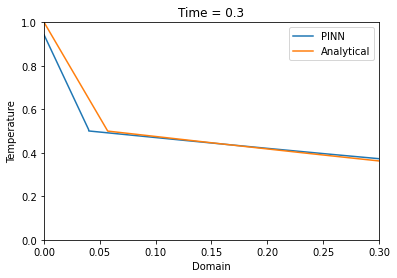

In [6]:
# Temperature Distribution

N_test = 2000

t_pred = 0.3

x_test = torch.linspace(0,x_r,N_test)
t_test = torch.ones(N_test)*t_pred
t_test = t_test.unsqueeze(-1)
x_test = x_test.unsqueeze(-1)

y1_pred = NN1( torch.cat((x_test, t_test),1) )
y2_pred = NN2( torch.cat((x_test, t_test),1) )
s_pred = NN3(t_test)

y1_pred = y1_pred.detach().numpy()
y2_pred = y2_pred.detach().numpy()
x_test = x_test.detach().numpy()
s_pred = s_pred.detach().numpy()
t_test = t_test.detach().numpy()

# PINN
y_pred = []
for i in range(N_test):
    if (s_pred[i]>x_test[i]):
        y_pred.append(y1_pred[i][0])
    elif (s_pred[i]<x_test[i] and y2_pred[i][0]>0):
        y_pred.append(y2_pred[i][0])
    else:
        y_pred.append(0)   
        
# Analytical
y_an = []
s_an = np.sqrt(k1*t_pred)*2*lam
for i in range(N_test):
    if (s_an>x_test[i]):
        y_an.append( left_temp + (-left_temp+melt_temp)*math.erf( x_test[i]/( 2*np.sqrt(k1*t_test[i]) ) )/ math.erf(lam) )
    else:
        y_an.append( right_temp + (-right_temp+melt_temp)*math.erfc( x_test[i]/( 2*np.sqrt(k2*t_test[i]) ) )/ math.erfc(lam*math.sqrt(k1/k2)))   
        
plt.plot(x_test, y_pred)
plt.plot(x_test, y_an)

plt.legend(['PINN', 'Analytical'])
plt.title('Time = '+ str(t_pred) )
plt.ylabel('Temperature')
plt.xlabel('Domain')
plt.xlim([0, 0.3])
plt.ylim([0, 1])

(0.0, 0.15)

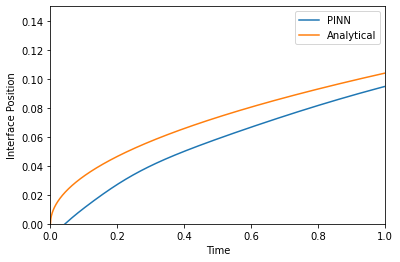

In [5]:
N_test = 2000

t_test = torch.linspace(t_i, t_f, N_test)
t_test = t_test.unsqueeze(-1)
s_pred = NN3(t_test)

t_test = t_test.detach().numpy()
s_pred = s_pred.detach().numpy()

plt.plot(t_test,s_pred)
plt.plot(t_test, np.sqrt(k1*t_test)*2*lam)
plt.legend(['PINN', 'Analytical'])
plt.xlabel('Time')
plt.ylabel('Interface Position')
plt.xlim([0, 1])
plt.ylim([0, 0.15])